# Interactive Voltage and Current Display

In [16]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import tresonator as T
import skrf as rf

In [18]:
# matched resonator measurement for SSA84
tres_exp = rf.Network('data/SSA84_TaskB_2022-07-28-matching_Arkadia_calibrated.s1p')
tres_exp.frequency.unit = 'MHz'

In [19]:
# SSA84 Arkadia optimized parameters to match the measurement above (done in another notebook)
P_in=20 # kW
L_DUT_opt=0.03825  # m
L_CEA_opt=0.04153  # m
Z_DUT_opt=0.005037  # Ohm
Z_CEA_opt=0.009385  # Ohm
add_loss_opt=0.9688  # Multiplicative coefficient to total conductivity

In [25]:
@interact(freq=(60,65,0.01), P_in=(10, 200,1), 
         L_DUT=(1, 200, 0.1), L_CEA=(1, 200, 0.1), 
         Z_DUT=(1e-6, 0.1, 1e-6), Z_CEA=(1e-6, 0.1, 1e-6))
def plot_voltage_current_vs_frequency(freq=62.38, P_in=P_in, 
                                      L_DUT=L_DUT_opt*1e3, L_CEA=L_CEA_opt*1e3, 
                                      Z_DUT=Z_DUT_opt, Z_CEA=Z_CEA_opt, 
                                      additional_losses=add_loss_opt):
    cfg_opt = T.Configuration(freq*1e6, P_in*1e3, L_DUT*1e-3, L_CEA*1e-3, 
                               Z_short_DUT=Z_DUT, Z_short_CEA=Z_CEA, 
                               additional_losses=additional_losses)

    # Calculates the voltage and current along the transmission lines
    L_CEA, L_DUT, V_CEA, V_DUT, I_CEA, I_DUT = cfg_opt.voltage_current()

    # Plotting V,I
    fig, ax = plt.subplots(3,1, sharex=False, figsize=(10,5))
    ax[0].plot(L_CEA, np.abs(V_CEA)/1e3,-L_DUT, np.abs(V_DUT)/1e3,  lw=2)
    ax[0].set_ylim(0, 60)
    ax[0].grid(True)
    ax[0].set_xlim(min(-L_DUT), max(L_CEA))
    ax[0].axvline(x=cfg_opt.L_Vprobe_CEA_fromT, ls='--', color='gray', lw=3)
    ax[0].axvline(x=-cfg_opt.L_Vprobe_DUT_fromT, ls='--', color='gray', lw=3)
    ax[0].set_ylabel('|V| [kV]', fontsize=14)
    ax[0].tick_params(labelsize=14)

    ax[1].plot(L_CEA, np.abs(I_CEA),-L_DUT, np.abs(I_DUT),  lw=2)
    ax[1].set_ylim(0, 3000)
    ax[1].grid(True)
    ax[1].axvline(x=cfg_opt.L_Vprobe_CEA_fromT, ls='--', color='gray', lw=3)
    ax[1].axvline(x=-cfg_opt.L_Vprobe_DUT_fromT, ls='--', color='gray', lw=3)
    ax[1].set_xlabel('L [m]', fontsize=14)
    ax[1].set_ylabel('|I| [A]', fontsize=14)
    ax[1].tick_params(labelsize=14)
    ax[1].set_xlim(min(-L_DUT), max(L_CEA))
    
    cfg_opt.circuit(rf.Frequency(62, 63, 1001, unit='MHz')).network.plot_s_db(ax=ax[2])
    tres_exp.plot_s_db(ax=ax[2], color='darkgray', ls='--')
    ax[2].set_xlim(62e6, 63e6)
    ax[2].set_ylim(-40, 0)

    


interactive(children=(FloatSlider(value=62.38, description='freq', max=65.0, min=60.0, step=0.01), IntSlider(v…

# Deducing the current at the short from the voltage at the probes

In [21]:
freq = 62.38
cfg_opt = T.Configuration(freq*1e6, P_in*1e3, L_DUT_opt, L_CEA_opt, 
                            Z_short_DUT=Z_DUT_opt, Z_short_CEA=Z_CEA_opt, 
                               additional_losses=add_loss_opt)

# varying the probe position to determine the sensibility 
cfg_opt.L_Vprobe_CEA_fromT = 1.236  # +/- 3 mm
cfg_opt.L_Vprobe_DUT_fromT = 0.660  # +/- 3 mm?

L_CEA, L_DUT, V_CEA, V_DUT, I_CEA, I_DUT = cfg_opt.voltage_current()

I_max_CEA = np.abs(I_CEA[-1])
I_max_DUT = np.abs(I_DUT[-1])
V_max_CEA = np.max(np.abs(V_CEA))
V_max_DUT = np.max(np.abs(V_DUT))
V_probeCEA = np.abs(V_CEA[np.argmin(np.abs(L_CEA - cfg_opt.L_Vprobe_CEA_fromT))])
V_probeDUT = np.abs(V_DUT[np.argmin(np.abs(L_DUT - cfg_opt.L_Vprobe_DUT_fromT))])

In [22]:
coeffVprobeCEA_2_Vmax = V_max_CEA/V_probeCEA
print('VprobeCEA -> V max CEA:', coeffVprobeCEA_2_Vmax)

coeffVprobeDUT_2_Vmax = V_max_DUT/V_probeDUT
print('VprobeDUT -> V max DUT:',coeffVprobeDUT_2_Vmax)

coeffVprobeCEA_2_Imax = I_max_CEA/V_probeCEA
print('VprobeCEA -> I short CEA:', coeffVprobeCEA_2_Imax)

coeffVprobeDUT_2_Imax = I_max_DUT/V_probeDUT
print('VprobeDUT -> I short DUT:',coeffVprobeDUT_2_Imax)

VprobeCEA -> V max CEA: 1.0031203682262384
VprobeDUT -> V max DUT: 1.2842791840489434
VprobeCEA -> I short CEA: 0.0337109785482888
VprobeDUT -> I short DUT: 0.06829468196254714


<IPython.core.display.Javascript object>


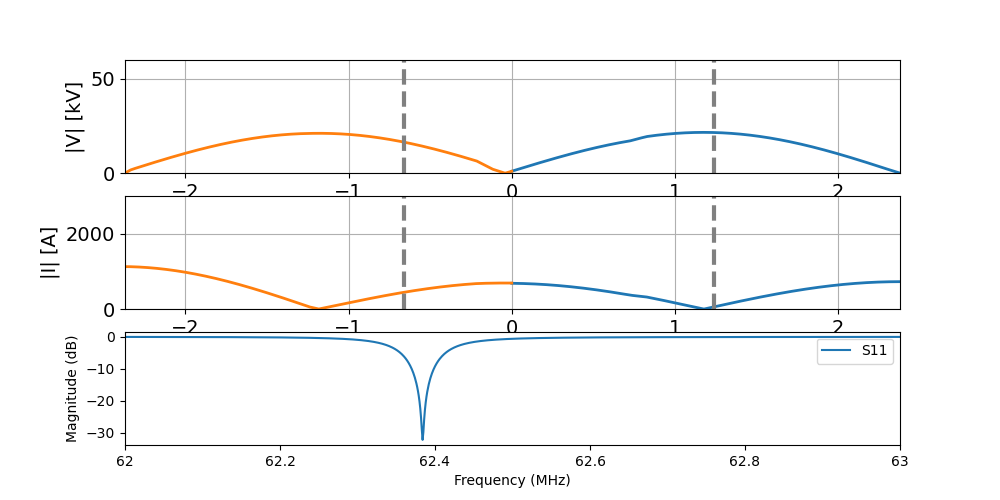

(62000000.0, 63000000.0)

In [23]:
# Plotting V,I
fig, ax = plt.subplots(3,1, sharex=False, figsize=(10,5))

ax[0].plot(L_CEA, np.abs(V_CEA)/1e3,-L_DUT, np.abs(V_DUT)/1e3,  lw=2)
ax[0].set_ylim(0, 60)
ax[0].grid(True)
ax[0].set_xlim(min(-L_DUT), max(L_CEA))
ax[0].axvline(x=cfg_opt.L_Vprobe_CEA_fromT, ls='--', color='gray', lw=3)
ax[0].axvline(x=-cfg_opt.L_Vprobe_DUT_fromT, ls='--', color='gray', lw=3)
ax[0].set_ylabel('|V| [kV]', fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].plot(L_CEA, np.abs(I_CEA),-L_DUT, np.abs(I_DUT),  lw=2)
ax[1].set_ylim(0, 3000)
ax[1].grid(True)
ax[1].axvline(x=cfg_opt.L_Vprobe_CEA_fromT, ls='--', color='gray', lw=3)
ax[1].axvline(x=-cfg_opt.L_Vprobe_DUT_fromT, ls='--', color='gray', lw=3)
ax[1].set_xlabel('L [m]', fontsize=14)
ax[1].set_ylabel('|I| [A]', fontsize=14)
ax[1].tick_params(labelsize=14)
ax[1].set_xlim(min(-L_DUT), max(L_CEA))

cfg_opt.circuit(rf.Frequency(62, 63, 1001, unit='MHz')).network.plot_s_db(ax=ax[2])
ax[2].set_xlim(62e6, 63e6)

In [24]:
cfg_opt

T-resonator config: f=62.38 MHz, P_in=20.0 kW, L_DUT=0.03825 m, L_CEA=0.04153 m